# Portfolio Optimization with Quadratic Programming

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp

## Data

In [2]:
import os
os.chdir(os.path.expanduser('../data'))

from dotenv import load_dotenv
load_dotenv()

from DataProvider import DataProvider

In [3]:
data_provider = DataProvider()
df_countries, benchmark = data_provider.get_etf_data()
days_to_recalculate = data_provider.get_days_to_recalculate()

In [4]:
data_period = df_countries.loc[days_to_recalculate.iloc[21]:days_to_recalculate.iloc[22]]
data_period

,United States,Japan,United Kingdom,Canada,France,Switzerland,Germany,Australia,Netherlands,Sweden,...,Norway,China,Taiwan,India,Korea,Brazil,Russia,South Africa,Mexico,Malaysia
2000-10-04,93.4411,39.3718,15.6950,10.8081,13.2245,10.3252,11.8108,3.6112,13.3252,10.9221,...,8.1982,16.8484,13.8798,6.3707,12.1416,8.2272,6.1849,11.1010,9.7495,7.2860
2000-10-05,93.7663,39.1895,15.6401,10.8494,13.0575,10.3252,11.7724,3.6112,13.2145,10.9221,...,8.1271,17.5344,14.2783,6.2990,12.1898,8.3129,6.0335,10.9036,9.7495,7.1105
2000-10-06,91.7341,38.6427,15.4206,10.7256,12.8237,10.1988,11.5415,3.4705,13.2883,10.6413,...,8.1563,17.5344,14.6103,6.2562,12.2380,8.2272,5.8847,10.8136,9.3913,7.1105
2000-10-09,91.0431,38.6427,15.3109,10.6431,12.6233,9.9459,11.5031,3.4705,13.1407,10.2356,...,8.0940,16.6499,14.6767,6.2016,11.5634,7.8559,5.7921,10.6768,9.2719,7.2860
2000-10-10,89.5393,38.6427,15.2560,10.6019,12.6233,10.0302,11.4646,3.4236,13.0668,10.2044,...,8.0768,16.5596,14.4775,6.0436,11.8043,7.9987,5.8549,10.5811,9.4311,7.1983
2000-10-11,88.7873,37.7313,15.1462,10.3956,12.4564,9.9881,11.2722,3.4939,12.8823,9.8923,...,7.9984,16.0180,14.4111,5.8381,11.2262,8.0844,5.6546,10.3933,9.1526,7.1105
2000-10-12,86.5722,37.1844,15.0914,10.1481,12.1558,9.9459,11.0414,3.3767,12.9192,9.8611,...,7.9660,15.9519,13.6806,5.8905,10.5998,7.7987,5.6260,10.2572,8.7546,7.2860
2000-10-13,89.4580,38.0958,15.2560,10.3956,12.3562,9.8195,11.2338,3.4001,13.1038,10.1108,...,7.8892,15.3261,13.8134,5.6925,10.7925,7.8844,5.5752,10.2071,8.9934,7.6372
2000-10-16,89.8644,37.7313,15.2560,10.4369,12.3562,9.6088,11.1953,3.4001,12.6977,9.9860,...,7.7973,15.6209,12.8836,5.7144,10.7925,7.9701,5.8927,10.2352,8.9536,7.8128
2000-10-17,87.6290,37.0022,15.0914,10.2718,12.2894,9.5666,11.1568,3.3767,12.4393,9.5803,...,7.6569,15.4464,13.2157,5.6170,10.2626,7.7702,5.8944,10.2057,8.7546,7.6372


In [5]:
acwi_weights = data_provider.get_acwi_weights()
period_year = str(data_period.index[0].year)
acwi_weights = acwi_weights.loc[period_year]
acwi_weights

,United States,Japan,United Kingdom,Canada,France,Switzerland,Germany,Australia,Netherlands,Sweden,...,Norway,China,Taiwan,India,Korea,Brazil,Russia,South Africa,Mexico,Malaysia
2000-01-01,49.71,10.17,10.88,2.26,3.71,3.29,3.57,1.49,1.55,1.2,...,0.4,0.12,0.89,0.32,0.47,0.72,0.3,0.63,0.61,0.31


## Returns and variance

In [6]:
returns = np.log(data_period).diff().dropna()
cov_returns = returns.cov()
mean_returns = returns.mean()

In [7]:
mean_returns

United States     0.000028
Japan            -0.001225
United Kingdom   -0.000152
Canada           -0.003813
France           -0.001000
Switzerland       0.000704
Germany           0.001394
Australia        -0.001144
Netherlands       0.000240
Sweden           -0.003490
Hong Kong        -0.001812
Spain            -0.001455
Italy             0.002121
Singapore         0.001986
Denmark          -0.002439
Finland           0.001950
Belgium           0.000853
Norway            0.001082
China            -0.001228
Taiwan           -0.000418
India            -0.002019
Korea            -0.002121
Brazil           -0.005121
Russia           -0.003156
South Africa     -0.001695
Mexico           -0.000178
Malaysia          0.004476
dtype: float64

In [8]:
cov_returns

,United States,Japan,United Kingdom,Canada,France,Switzerland,Germany,Australia,Netherlands,Sweden,...,Norway,China,Taiwan,India,Korea,Brazil,Russia,South Africa,Mexico,Malaysia
United States,0.000277,0.000179,0.000191,0.000286,0.000195,0.000084,0.000206,1.147846e-04,0.000186,0.000380,...,0.000093,0.000024,-0.000004,0.000041,0.000278,0.000217,0.000088,0.000156,0.000258,0.000067
Japan,0.000179,0.000233,0.000188,0.000259,0.000170,0.000079,0.000184,2.165221e-05,0.000188,0.000341,...,0.000128,-0.000002,0.000106,0.000089,0.000272,0.000121,0.000054,0.000144,0.000216,0.000124
United Kingdom,0.000191,0.000188,0.000322,0.000267,0.000210,0.000158,0.000202,8.184611e-06,0.000260,0.000482,...,0.000132,-0.000088,0.000048,0.000065,0.000096,0.000126,0.000015,0.000138,0.000258,0.000104
Canada,0.000286,0.000259,0.000267,0.000610,0.000289,0.000093,0.000294,5.802660e-06,0.000250,0.000537,...,0.000193,0.000081,0.000165,0.000029,0.000503,0.000380,0.000221,0.000265,0.000182,0.000110
France,0.000195,0.000170,0.000210,0.000289,0.000311,0.000128,0.000288,3.160852e-05,0.000230,0.000408,...,0.000166,0.000072,0.000161,0.000129,0.000356,0.000227,0.000174,0.000273,0.000220,0.000010
Switzerland,0.000084,0.000079,0.000158,0.000093,0.000128,0.000246,0.000138,8.096257e-06,0.000211,0.000313,...,0.000093,0.000031,-0.000042,0.000122,0.000126,0.000156,-0.000020,0.000055,0.000216,-0.000085
Germany,0.000206,0.000184,0.000202,0.000294,0.000288,0.000138,0.000323,2.039099e-05,0.000225,0.000438,...,0.000173,0.000078,0.000142,0.000139,0.000286,0.000234,0.000161,0.000253,0.000226,-0.000030
Australia,0.000115,0.000022,0.000008,0.000006,0.000032,0.000008,0.000020,2.537766e-04,-0.000017,-0.000024,...,-0.000019,-0.000020,0.000028,-0.000013,0.000030,0.000023,0.000010,0.000029,0.000061,-0.000044
Netherlands,0.000186,0.000188,0.000260,0.000250,0.000230,0.000211,0.000225,-1.727639e-05,0.000368,0.000476,...,0.000163,-0.000013,0.000088,0.000157,0.000243,0.000180,-0.000014,0.000184,0.000258,0.000013
Sweden,0.000380,0.000341,0.000482,0.000537,0.000408,0.000313,0.000438,-2.420439e-05,0.000476,0.000982,...,0.000269,-0.000051,0.000031,0.000172,0.000426,0.000486,0.000099,0.000312,0.000479,0.000046


### Random portfolios

In [9]:
n = mean_returns.shape[0]
list_ret_p = []
list_std_p = []
list_w = []
for _ in range(10000):
    w = np.random.rand(n)           # random weights   
    w = w / np.sum(w)               # scaled to 1
    ret_p = mean_returns.dot(w)
    std_p = np.sqrt(w @ cov_returns.values @ w)  
    list_ret_p.append(ret_p)
    list_std_p.append(std_p)
    list_w.append(w)

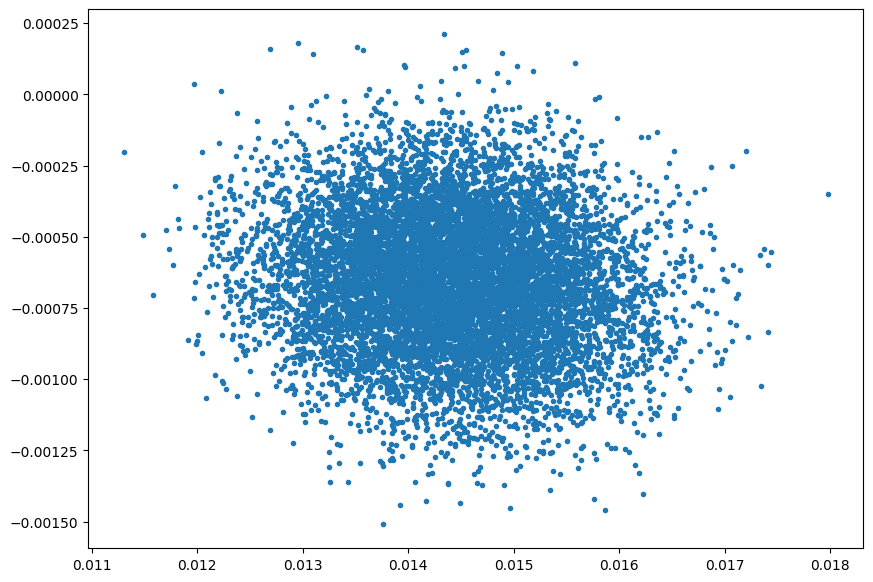

In [10]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(list_std_p, list_ret_p, '.')

In [11]:
list_w[0]

array([0.07014324, 0.07427492, 0.08474709, 0.05897476, 0.02095503,
       0.04838512, 0.03213982, 0.03398811, 0.04998741, 0.00487065,
       0.04853838, 0.04501828, 0.03963502, 0.01840263, 0.00409015,
       0.00205082, 0.04404948, 0.0045188 , 0.03833467, 0.00764799,
       0.06032628, 0.02145513, 0.07041156, 0.0198158 , 0.00028559,
       0.03975753, 0.05719574])

### Constraints

'Normal' contraints

In [12]:
w = cp.Variable(acwi_weights.shape[1])
constraints = [cp.sum(w) == 1]
i = 0

for country in acwi_weights.columns:
    weights = round(acwi_weights.loc[:, country].values[0]/100, 4)
    min_weight = round(weights*0.5, 4)
    if min_weight < 0.001:
        min_weight = 0.001

    max_weight = round(weights*2, 4)
    if max_weight < 0.03:
        max_weight = 0.03
    elif max_weight > 0.75:
        max_weight = 0.75

    constraints += [
        w[i] >= min_weight,
        w[i] <= max_weight
    ]
    
    print(i, country, '(', weights, ') from', min_weight, 'to', max_weight)
    i += 1

0 United States ( 0.4971 ) from 0.2486 to 0.75
1 Japan ( 0.1017 ) from 0.0508 to 0.2034
2 United Kingdom ( 0.1088 ) from 0.0544 to 0.2176
3 Canada ( 0.0226 ) from 0.0113 to 0.0452
4 France ( 0.0371 ) from 0.0186 to 0.0742
5 Switzerland ( 0.0329 ) from 0.0164 to 0.0658
6 Germany ( 0.0357 ) from 0.0178 to 0.0714
7 Australia ( 0.0149 ) from 0.0074 to 0.03
8 Netherlands ( 0.0155 ) from 0.0078 to 0.031
9 Sweden ( 0.012 ) from 0.006 to 0.03
10 Hong Kong ( 0.0101 ) from 0.005 to 0.03
11 Spain ( 0.0132 ) from 0.0066 to 0.03
12 Italy ( 0.0187 ) from 0.0094 to 0.0374
13 Singapore ( 0.0038 ) from 0.0019 to 0.03
14 Denmark ( 0.003 ) from 0.0015 to 0.03
15 Finland ( 0.0045 ) from 0.0022 to 0.03
16 Belgium ( 0.0038 ) from 0.0019 to 0.03
17 Norway ( 0.004 ) from 0.002 to 0.03
18 China ( 0.0012 ) from 0.001 to 0.03
19 Taiwan ( 0.0089 ) from 0.0044 to 0.03
20 India ( 0.0032 ) from 0.0016 to 0.03
21 Korea ( 0.0047 ) from 0.0024 to 0.03
22 Brazil ( 0.0072 ) from 0.0036 to 0.03
23 Russia ( 0.003 ) from 0.

Tight constraints

In [13]:
w = cp.Variable(acwi_weights.shape[1])
constraints = [cp.sum(w) == 1]
i = 0

for country in acwi_weights.columns:
    weights = round(acwi_weights.loc[:, country].values[0]/100, 4)
    min_weight = round(weights*0.7, 4)
    if min_weight < 0.001:
        min_weight = 0.001

    max_weight = round(weights*1.5, 4)
    if max_weight < 0.02:
        max_weight = 0.02
    elif max_weight > 0.7:
        max_weight = 0.7

    constraints += [
        w[i] >= min_weight,
        w[i] <= max_weight
    ]
    
    print(i, country, '(', weights, ') from', min_weight, 'to', max_weight)
    i += 1

0 United States ( 0.4971 ) from 0.348 to 0.7
1 Japan ( 0.1017 ) from 0.0712 to 0.1526
2 United Kingdom ( 0.1088 ) from 0.0762 to 0.1632
3 Canada ( 0.0226 ) from 0.0158 to 0.0339
4 France ( 0.0371 ) from 0.026 to 0.0556
5 Switzerland ( 0.0329 ) from 0.023 to 0.0494
6 Germany ( 0.0357 ) from 0.025 to 0.0536
7 Australia ( 0.0149 ) from 0.0104 to 0.0224
8 Netherlands ( 0.0155 ) from 0.0108 to 0.0232
9 Sweden ( 0.012 ) from 0.0084 to 0.02
10 Hong Kong ( 0.0101 ) from 0.0071 to 0.02
11 Spain ( 0.0132 ) from 0.0092 to 0.02
12 Italy ( 0.0187 ) from 0.0131 to 0.028
13 Singapore ( 0.0038 ) from 0.0027 to 0.02
14 Denmark ( 0.003 ) from 0.0021 to 0.02
15 Finland ( 0.0045 ) from 0.0031 to 0.02
16 Belgium ( 0.0038 ) from 0.0027 to 0.02
17 Norway ( 0.004 ) from 0.0028 to 0.02
18 China ( 0.0012 ) from 0.001 to 0.02
19 Taiwan ( 0.0089 ) from 0.0062 to 0.02
20 India ( 0.0032 ) from 0.0022 to 0.02
21 Korea ( 0.0047 ) from 0.0033 to 0.02
22 Brazil ( 0.0072 ) from 0.005 to 0.02
23 Russia ( 0.003 ) from 0.0

Loose constraints

In [14]:
w = cp.Variable(acwi_weights.shape[1])
constraints = [cp.sum(w) == 1]
i = 0

for country in acwi_weights.columns:
    weights = round(acwi_weights.loc[:, country].values[0]/100, 4)
    min_weight = round(weights*0.3, 4)
    max_weight = round(weights*3, 4)
    if max_weight < 0.04:
        max_weight = 0.04
    elif max_weight > 0.8:
        max_weight = 0.8

    if min_weight <= 0.001:
        min_weight = 0
        constraints.append(w[i] <= max_weight)
    else:
        constraints += [
            w[i] >= min_weight,
            w[i] <= max_weight
        ]
    
    print(i, country, '(', weights, ') from', min_weight, 'to', max_weight)
    i += 1

0 United States ( 0.4971 ) from 0.1491 to 0.8
1 Japan ( 0.1017 ) from 0.0305 to 0.3051
2 United Kingdom ( 0.1088 ) from 0.0326 to 0.3264
3 Canada ( 0.0226 ) from 0.0068 to 0.0678
4 France ( 0.0371 ) from 0.0111 to 0.1113
5 Switzerland ( 0.0329 ) from 0.0099 to 0.0987
6 Germany ( 0.0357 ) from 0.0107 to 0.1071
7 Australia ( 0.0149 ) from 0.0045 to 0.0447
8 Netherlands ( 0.0155 ) from 0.0046 to 0.0465
9 Sweden ( 0.012 ) from 0.0036 to 0.04
10 Hong Kong ( 0.0101 ) from 0.003 to 0.04
11 Spain ( 0.0132 ) from 0.004 to 0.04
12 Italy ( 0.0187 ) from 0.0056 to 0.0561
13 Singapore ( 0.0038 ) from 0.0011 to 0.04
14 Denmark ( 0.003 ) from 0 to 0.04
15 Finland ( 0.0045 ) from 0.0013 to 0.04
16 Belgium ( 0.0038 ) from 0.0011 to 0.04
17 Norway ( 0.004 ) from 0.0012 to 0.04
18 China ( 0.0012 ) from 0 to 0.04
19 Taiwan ( 0.0089 ) from 0.0027 to 0.04
20 India ( 0.0032 ) from 0 to 0.04
21 Korea ( 0.0047 ) from 0.0014 to 0.04
22 Brazil ( 0.0072 ) from 0.0022 to 0.04
23 Russia ( 0.003 ) from 0 to 0.04
24 

### Efficient Frontier Calculations

In [15]:
def efficient_frontier(returns, w, constraints, n_samples=20):
    sigma = returns.cov().values
    mu = np.mean(returns, axis=0).values
    gamma = cp.Parameter(nonneg=True)
    ret = mu.T @ w
    risk = cp.quad_form(w, sigma)

    prob = cp.Problem(cp.Maximize(ret - gamma*risk), constraints)
    risk_data = np.zeros(n_samples)
    ret_data = np.zeros(n_samples)
    gamma_vals = np.logspace(-0.9, 10, num=n_samples)

    portfolio_weights = []
    for i in range(n_samples):
        gamma.value = gamma_vals[i]
        prob.solve()
        risk_data[i] = np.sqrt(risk.value)
        ret_data[i] = ret.value
        portfolio_weights.append(w.value)
    return ret_data, risk_data, portfolio_weights

In [16]:
ret_data, risk_data, portfolio_weights = efficient_frontier(returns, w, constraints)

### Optimal portfolio with Max Sharpe value

In [17]:
sharpes = ret_data/risk_data 
idx = np.argmax(sharpes)
optimal_ret, optimal_risk = ret_data[idx], risk_data[idx]
optimal_portfolio = pd.Series(portfolio_weights[idx],
                              index=returns.columns).round(3)

In [18]:
sharpes

array([ 0.10385556,  0.10385556,  0.11734155,  0.0773182 ,  0.00236128,
       -0.03361153, -0.04954651, -0.05022781, -0.05043888, -0.05049516,
       -0.05051018, -0.05051419, -0.05051526, -0.05051554, -0.05051562,
       -0.05051564, -0.05051565, -0.05051565, -0.05051565, -0.05051565])

Dibujamos la frontera eficiente y donde ocurre la cartera optima

In [19]:
optimal_portfolio

United States     0.800
Japan             0.288
United Kingdom    0.326
Canada            0.007
France            0.111
Switzerland       0.099
Germany           0.107
Australia         0.045
Netherlands       0.046
Sweden            0.004
Hong Kong         0.003
Spain             0.004
Italy             0.056
Singapore         0.040
Denmark          -0.580
Finland           0.040
Belgium           0.040
Norway            0.040
China             0.040
Taiwan            0.040
India             0.040
Korea             0.001
Brazil            0.002
Russia           -0.720
South Africa      0.040
Mexico            0.040
Malaysia          0.040
dtype: float64

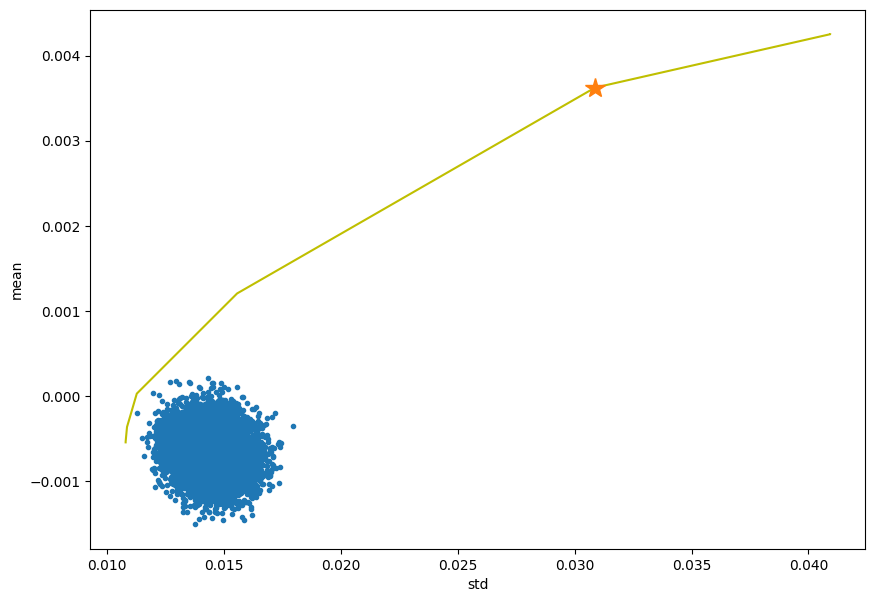

In [20]:
fig, ax = plt.subplots(figsize=(10, 7))
plt.plot(list_std_p, list_ret_p, '.')
ax.plot(risk_data, ret_data, 'y')
ax.plot(optimal_risk, optimal_ret, '*', markersize=15)
_ = ax.set_xlabel('std')
_ = ax.set_ylabel('mean')

### Dividing code into functions

In [21]:
def get_constraints(w, acwi_weights):
    constraints = [cp.sum(w) == 1]
    i = 0

    for country in acwi_weights.columns:
        weights = acwi_weights.loc[:, country].values[0]
        min_weight = round(weights*0.5/100, 3)
        if min_weight < 0.001:
            min_weight = 0.001

        max_weight = round(weights*2/100, 3)
        if max_weight < 0.03:
            max_weight = 0.03
        elif max_weight > 0.7:
            max_weight = 0.7

        constraints += [
            w[i] >= min_weight,
            w[i] <= max_weight
        ]
        i += 1
    
    return constraints

In [22]:
def get_optimal_portfolio(data_period, acwi_weights):
    returns = np.log(data_period).diff().dropna()

    w = cp.Variable(acwi_weights.shape[1])
    constraints = get_constraints(w, acwi_weights)

    ret_data, risk_data, portfolio_weights = efficient_frontier(
        returns, w, constraints)

    sharpes = ret_data/risk_data
    idx = np.argmax(sharpes)
    optimal_portfolio = pd.Series(portfolio_weights[idx],
                                  index=returns.columns).round(3)

    return optimal_portfolio

In [23]:
get_optimal_portfolio(data_period, acwi_weights)

United States     0.462
Japan             0.051
United Kingdom    0.054
Canada            0.011
France            0.019
Switzerland       0.066
Germany           0.071
Australia         0.007
Netherlands       0.031
Sweden            0.006
Hong Kong         0.005
Spain             0.007
Italy             0.037
Singapore         0.030
Denmark           0.002
Finland           0.030
Belgium           0.030
Norway            0.030
China             0.001
Taiwan            0.004
India             0.002
Korea             0.002
Brazil            0.004
Russia            0.002
South Africa      0.003
Mexico            0.003
Malaysia          0.030
dtype: float64

### Test PortfolioOptimizer class

In [24]:
from PortfolioOptimizer import PortfolioOptimizer

In [29]:
optimizer = PortfolioOptimizer()
w, constraints = optimizer.get_normal_constraints(acwi_weights)
optimizer.get_optimal_portfolio(data_period, w, constraints)

United States     0.462
Japan             0.051
United Kingdom    0.054
Canada            0.011
France            0.019
Switzerland       0.066
Germany           0.071
Australia         0.007
Netherlands       0.031
Sweden            0.006
Hong Kong         0.005
Spain             0.007
Italy             0.037
Singapore         0.030
Denmark           0.002
Finland           0.030
Belgium           0.030
Norway            0.030
China             0.001
Taiwan            0.004
India             0.002
Korea             0.002
Brazil            0.004
Russia            0.002
South Africa      0.003
Mexico            0.003
Malaysia          0.030
dtype: float64

## Constraint using ranking

Building constraints for ranked countries from Learning to Rate model

In [26]:
random_ranking = list(range(len(data_provider.selected_countries)))
np.random.shuffle(random_ranking)

ranked_countries = pd.Series(random_ranking, index=data_provider.selected_countries)
ranked_countries

United States     10
Japan             13
United Kingdom     0
Canada            15
France            16
Switzerland       12
Germany            9
Australia          4
Netherlands        3
Sweden             8
Hong Kong         24
Spain              1
Italy             21
Singapore         17
Denmark           23
Finland           22
Belgium            6
Norway             2
China             26
Taiwan             5
India              7
Korea             19
Brazil            25
Russia            20
South Africa      18
Mexico            11
Malaysia          14
dtype: int64

In [27]:
acwi_weights

,United States,Japan,United Kingdom,Canada,France,Switzerland,Germany,Australia,Netherlands,Sweden,...,Norway,China,Taiwan,India,Korea,Brazil,Russia,South Africa,Mexico,Malaysia
2000-01-01,49.71,10.17,10.88,2.26,3.71,3.29,3.57,1.49,1.55,1.2,...,0.4,0.12,0.89,0.32,0.47,0.72,0.3,0.63,0.61,0.31


In [28]:
w = cp.Variable(acwi_weights.shape[1])
constraints = [cp.sum(w) == 1]
i = 0

for country in acwi_weights.columns:
    benchmark_weight = acwi_weights.loc[:, country].values[0]
    benchmark_weight = round(benchmark_weight/100, 3)
    rank = ranked_countries[country]

    if i < 3:
        if rank < 10:
            min_weight = benchmark_weight
            max_weight = benchmark_weight*2
            if max_weight > 0.7:
                max_weight = 0.7
        else:
            min_weight = benchmark_weight*0.5
            max_weight = benchmark_weight
    else:
        min_weight = 0.001
        max_weight = 0.03

    constraints += [
        w[i] >= min_weight,
        w[i] <= max_weight
    ]
    print(i, country, '(', benchmark_weight, ') from',
          min_weight, 'to', max_weight)

    if i >= 3 and rank > 0:
        higher_ranked_country = ranked_countries[
            ranked_countries == rank-1].index[0]
        higher_ranked_country_idx = acwi_weights.columns.get_loc(
            higher_ranked_country)
        if higher_ranked_country_idx >= 3:
            constraints.append(w[i] <= w[higher_ranked_country_idx])
            print(country, '<=', higher_ranked_country)
        elif rank > 1:
            higher_ranked_country = ranked_countries[
                ranked_countries == rank-2].index[0]
            higher_ranked_country_idx = acwi_weights.columns.get_loc(
                higher_ranked_country)
            if higher_ranked_country_idx >= 3:
                constraints.append(w[i] <= w[higher_ranked_country_idx])
                print(country, '<=', higher_ranked_country)

    i += 1

0 United States ( 0.497 ) from 0.2485 to 0.497
1 Japan ( 0.102 ) from 0.051 to 0.102
2 United Kingdom ( 0.109 ) from 0.109 to 0.218
3 Canada ( 0.023 ) from 0.001 to 0.03
Canada <= Malaysia
4 France ( 0.037 ) from 0.001 to 0.03
France <= Canada
5 Switzerland ( 0.033 ) from 0.001 to 0.03
Switzerland <= Mexico
6 Germany ( 0.036 ) from 0.001 to 0.03
Germany <= Sweden
7 Australia ( 0.015 ) from 0.001 to 0.03
Australia <= Netherlands
8 Netherlands ( 0.016 ) from 0.001 to 0.03
Netherlands <= Norway
9 Sweden ( 0.012 ) from 0.001 to 0.03
Sweden <= India
10 Hong Kong ( 0.01 ) from 0.001 to 0.03
Hong Kong <= Denmark
11 Spain ( 0.013 ) from 0.001 to 0.03
12 Italy ( 0.019 ) from 0.001 to 0.03
Italy <= Russia
13 Singapore ( 0.004 ) from 0.001 to 0.03
Singapore <= France
14 Denmark ( 0.003 ) from 0.001 to 0.03
Denmark <= Finland
15 Finland ( 0.005 ) from 0.001 to 0.03
Finland <= Italy
16 Belgium ( 0.004 ) from 0.001 to 0.03
Belgium <= Taiwan
17 Norway ( 0.004 ) from 0.001 to 0.03
Norway <= Spain
18 C